# Импорт библиотек и установка зависимостей

In [1]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/pycups-2.0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/PyPDF3-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.6 MB/s eta 0:00:00m eta 0:00:010:00:01


In [1]:
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Импорт данных

In [28]:
df = pd.read_csv('.././data/preprocessed_ipp_factors.csv', index_col='date')

In [29]:
df.head(3)

,goal,news,consumer_price,fin_rez_ipp,bussines_clim,curs,rzd
date,,,,,,,
1/31/2015,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6
2/28/2015,99.8,-1.756337,1156.01,-11.936877,2.572276,64.518174,92.5
3/31/2015,101.9,-1.972270,1167.50,-7.194668,6.963493,60.363090,103.0


# Добавление столбцов с лаггом

### Лаги для признаков:
- __Новостной индекс ЦБ (news):__ 1 месяц
- __Индекс цен на электроэнергию в первой ценовой зоне (consumer_price):__ 0 месяцев
- __Промышленность (fin_rez_lag):__ 2 месяца
- __Индикатор бизнес климата (bussines_clim):__ 2 месяца
- __Курс рубля (curs):__ 0 месяцев
- __Погрузка на сети РЖД (rzd):__ 1 месяц

In [30]:
df.head(1)

,goal,news,consumer_price,fin_rez_ipp,bussines_clim,curs,rzd
date,,,,,,,
1/31/2015,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6


In [31]:
for i in range(1,4):
    df[f'goal_lag_{i}'] = df['goal'].shift(i) ** 2
    df[f'news_lag_{i}'] = df['news'].shift(i)
    df[f'bussines_clim_lag_{i}'] = df['bussines_clim'].shift(i)
    df[f'fin_rez_lag_{i}'] = df['fin_rez_ipp'].shift(i)
    df[f'rzd_lag_{i}'] = df['rzd'].shift(i)

conc_d_wda = df.copy()
concd_sub = conc_d_wda.fillna(method='pad')

In [33]:
concd_sub.head(1)

,goal,news,consumer_price,fin_rez_ipp,bussines_clim,curs,rzd,goal_lag_1,news_lag_1,bussines_clim_lag_1,...,goal_lag_2,news_lag_2,bussines_clim_lag_2,fin_rez_lag_2,rzd_lag_2,goal_lag_3,news_lag_3,bussines_clim_lag_3,fin_rez_lag_3,rzd_lag_3
date,,,,,,,,,,,,,,,,,,,,,
1/31/2015,101.3,-1.551464,1049.05,-20.468123,-8.734671,65.153087,96.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Пустая матрица для прогнозов

In [34]:
new_dr = pd.date_range(concd_sub.index[0], periods=3, freq='MS')
my_forecast = pd.DataFrame([concd_sub.goal[-1]] * 3, index=new_dr, columns=['mf'])
conf_vect = np.linspace(2, 5, 3)
my_forecast['ci_l'] = my_forecast.mf + conf_vect
my_forecast['ci_h'] = my_forecast.mf - conf_vect

In [36]:
#экзогенные переменные для прогнозирования на 1 месяц вперед
exog_var = [
    'goal_lag_1',
    'goal_lag_2',
    'goal_lag_3',
    'CONSUMER_PRICE_1',
    'fin_rez_lag_1',
    'news',
    'bussines_clim_lag_1',
]

In [ ]:
Y_train = train.goal
X_train = train[exog_var]
Y_test = test.goal
X_test = test[exog_var]

In [ ]:
train_predict, test_predict, mse_test, model = make_gdb(Y_train, X_train, Y_test, X_test)

In [6]:
def prep_forec(train, test):
    

    



    
    test_predict = pd.Series(test_predict, index=Y_test.index)
    my_forecast.loc[Y_test.index[0]].mf = test_predict.loc[Y_test.index[0]]

    for mlag in range (1, 3):
        data_forecast = my_forecast.index[mlag]
        print(data_forecast)
        exog_var = [i for i in conc_d_wda.columns if i[-5:] == f'lag_{mlag + 1}']
        exog_var_sort = conc_d_wda[['goal']+exog_var].corr()['goal'].sort_values(ascending=False).index[1:].tolist()
        print(exog_var)
        Y_train = train.goal
        X_train = train[exog_var_sort]
        Y_test = test.goal
        X_test = test[exog_var_sort]
        train_predict, test_predict, mse_test, model = make_gdb(Y_train, X_train, Y_test, X_test)
        my_forecast.loc[data_forecast].mf = model.predict(X_test[exog_var_sort])[mlag]

    conf_vect = np.linspace(1,1.5,3)
    my_forecast_v2 = my_forecast.copy()
    my_forecast_v2['ci_l'] = my_forecast_v2.mf+conf_vect
    my_forecast_v2['ci_h'] = my_forecast_v2.mf-conf_vect

    mrow = [Y_train.index[-1]]+[Y_train[-1]]*3
    my_forecast_v2 = my_forecast_v2.reset_index()
    my_forecast_v2.loc[4] = mrow
    my_forecast_v2 = my_forecast_v2.set_index('index').sort_index()

    date_rn = pd.date_range(start=my_forecast_v2.index[-1],
                            end = f'{my_forecast_v2.index[-1].year}-12-31', freq='MS')
    forec_last = pd.DataFrame([my_forecast_v2.mf[-1]]*len(date_rn), index = date_rn, columns=['mf'])
    
    conf_vect = np.linspace(1.5, 3, len(forec_last))
    forec_last['ci_l'] = forec_last.mf + conf_vect
    forec_last['ci_h'] = forec_last.mf - conf_vect

    return my_forecast_v2, forec_last

# 

In [7]:
def make_gdb(Y_train, X_train, Y_test, X_test):
    model = CatBoostRegressor(
        iterations=4,
        learning_rate=1,
        depth=4,
        verbose=False, 
        loss_function='RMSE',
        l2_leaf_reg = 1,
        # gpu=True
    )
    
    grid = {
        'iterations':    [2, 4, 6, 8, 15], 
        'depth':         [3, 5, 6, 8],
        'l2_leaf_reg':   [0.01, 0.1, 0.5, 1, 1.5],
        'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
    }


    res = model.grid_search(
        grid, X_train, Y_train, 
        calc_cv_statistics=True,
        search_by_train_test_split=True,
        refit=True,
        verbose=0,
        cv=tscv
    )
    
    model = CatBoostRegressor(**res['params'], verbose = False)
    print(res['params'])

    par_dict = {'depth': 6, 'iterations': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 2}
    model = CatBoostRegressor(**par_dict, verbose = False)

    model.fit(X_train, Y_train)
    preds = model.predict(X_train)

    train_predict = model.predict(X_train)
    print('mse train', np.round(mean_squared_error(Y_train, train_predict), 3))
    print('r2_score', np.round(r2_score(Y_train, train_predict), 3))

    test_predict = model.predict(X_test)
    mse_test = np.round(mean_squared_error(Y_test, test_predict), 3)
    print('mse test', mse_test)
    return train_predict, test_predict, mse_test, model

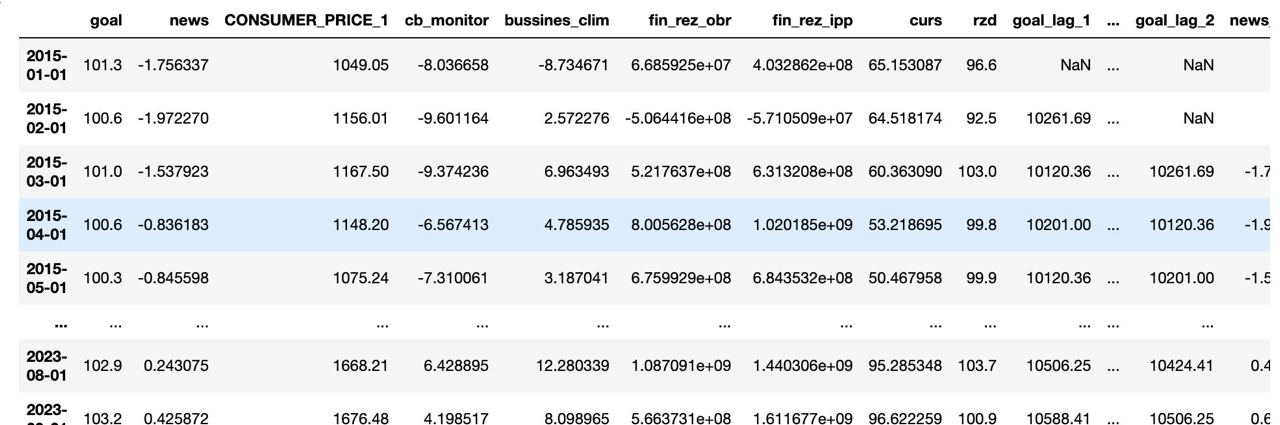